### Time Series Changes and Versioning with TimeDB

This notebook demonstrates how to manually change values, tags, and annotations of a time series and view all versions of the changes.

#### What you'll learn:
1. **Creating and inserting a time series** - Insert initial time series data
2. **Reading and visualizing time series** - Read and plot the original data
3. **Updating time series** - Manually change values, tags, and annotations
4. **Reading all versions** - Query all versions of the time series using `all_versions` flag
5. **Visualizing changes** - Plot original vs updated versions to see the differences
6. **Batch updates and version history** - Update multiple values and view complete version history with metadata

**Key Concepts:**
- TimeDB maintains a full version history of all changes
- Each update creates a new version while keeping the old version for audit trail
- The `all_versions=True` flag allows you to see all historical versions with `changed_by` and `change_time` metadata
- The `tags_and_annotations=True` flag includes tags and annotations as DataFrame columns
- When using `all_versions=True` with `return_value_id=True`, the DataFrame uses a MultiIndex `(valid_time, value_id)` to preserve multiple versions
- Updates can modify values, annotations, and tags independently or together
- Using `value_id` from the initial read makes updates simple - no need to query the database again


In [1]:
import timedb as td
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import numpy as np

# Load environment variables (for database connection)
from dotenv import load_dotenv
load_dotenv()

print("✓ Imports successful")


✓ Imports successful


## Part 1: Create and Insert a Time Series

First, let's create the database schema and insert an initial time series.


In [2]:
# Delete database schema
td.delete()

# Create database schema (includes support for updates, tags, and annotations)
td.create()


Creating database schema...
✓ Schema created successfully


In [3]:
# Create a time series with hourly data for 24 hours
base_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
times = [base_time + timedelta(hours=i) for i in range(24)]

# Generate sample data: temperature values with a daily pattern
# Starting at 15°C, rising to 25°C during the day, then cooling down
np.random.seed(42)  # For reproducibility
base_temp = 20.0
amplitude = 5.0
temperature_values = [
    base_temp + amplitude * np.sin(2 * np.pi * i / 24) + np.random.normal(0, 0.5)
    for i in range(24)
]
temperature_values = [round(v, 2) for v in temperature_values]

# Create DataFrame
df = pd.DataFrame({
    'valid_time': times,
    'temperature': temperature_values
})

# Insert the time series
result = td.insert_run(df=df)

print(f"✓ Time series inserted successfully!")
print(f"  Run ID: {result.run_id}")
print(f"  Series ID: {result.series_ids['temperature']}")
print(f"  Time range: {times[0]} to {times[-1]}")
print(f"  Number of data points: {len(df)}")

# Store the series_id for later use
series_id = result.series_ids['temperature']


Data values inserted successfully.
✓ Time series inserted successfully!
  Run ID: fe63180a-a3bd-41a7-a84d-4f64462c02a2
  Series ID: b3af9adf-db64-4ef6-ade8-54333d06fae5
  Time range: 2025-01-01 00:00:00+00:00 to 2025-01-01 23:00:00+00:00
  Number of data points: 24


## Part 2: Read and Plot the Original Time Series

Now let's read back the time series and visualize it.

In [4]:
# Read the time series with return_value_id=True so we can use value_id later for updates
df_read = td.read(return_value_id=True)

print(f"✓ Read {len(df_read)} data points")
print(f"\nDataFrame shape: {df_read.shape}")
print(f"\nColumns: {list(df_read.columns)}")
print(f"\nFirst few rows:")
df_read.head(10)


✓ Read 24 data points

DataFrame shape: (24, 2)

Columns: ['temperature', 'value_id']

First few rows:


series_key,temperature,value_id
valid_time,,
2025-01-01 00:00:00+00:00,20.25,1
2025-01-01 01:00:00+00:00,21.22,2
2025-01-01 02:00:00+00:00,22.82,3
2025-01-01 03:00:00+00:00,24.3,4
2025-01-01 04:00:00+00:00,24.21,5
2025-01-01 05:00:00+00:00,24.71,6
2025-01-01 06:00:00+00:00,25.79,7
2025-01-01 07:00:00+00:00,25.21,8
2025-01-01 08:00:00+00:00,24.1,9


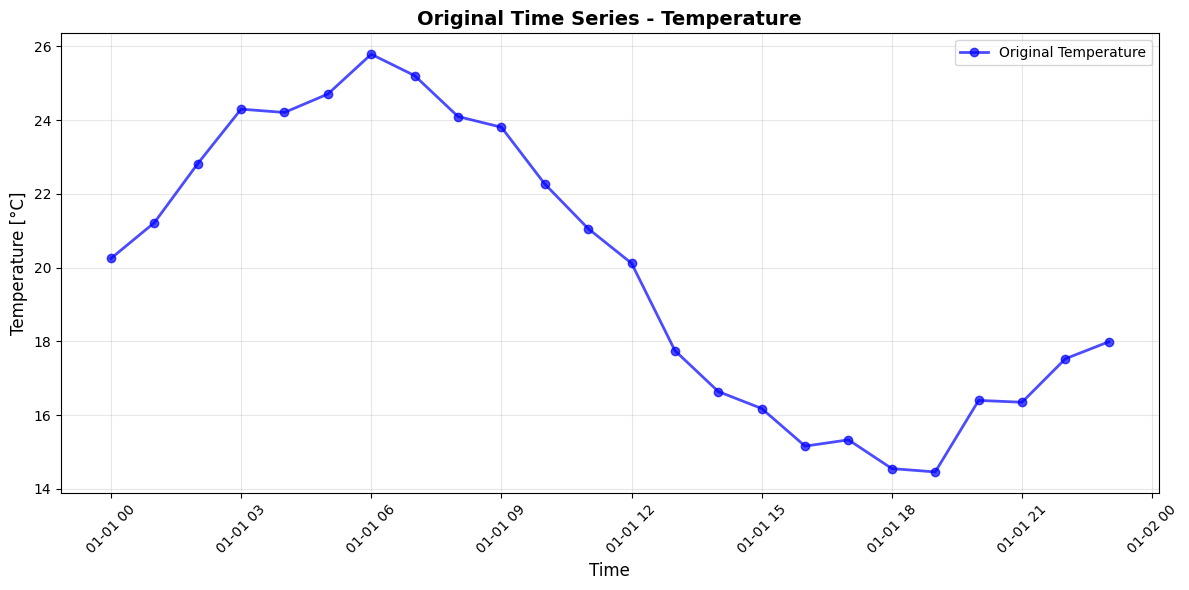

✓ Original time series plotted successfully!


In [5]:
# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(df_read.index, df_read['temperature'], marker='o', linewidth=2, markersize=6, 
         label='Original Temperature', color='blue', alpha=0.7)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature [°C]', fontsize=12)
plt.title('Original Time Series - Temperature', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ Original time series plotted successfully!")


## Part 3: Update the Time Series

Now we'll make an update to change a value, add a tag, and add an annotation. We'll update the value at hour 2 (early in the series) to correct what appears to be an anomalous reading.


In [6]:
# The time point we want to update (hour 2, early in the series for better visibility)
update_time = base_time + timedelta(hours=2)

# Get the original value for reference
original_value = df_read.loc[update_time, 'temperature']
print(f"Original value at {update_time}: {original_value}°C")

# Get the value_id for the time point we want to update (from the first read)
value_id = df_read.loc[update_time, 'value_id']
print(f"Value ID for update: {value_id}")

# Create an update that:
# 1. Changes the value to a corrected temperature (e.g., 24.5°C instead of the original)
# 2. Adds an annotation explaining the correction
# 3. Adds tags to mark this as reviewed and corrected
corrected_value = 24.5

print(f"\nUpdating to: {corrected_value}°C")
print(f"Adding annotation: 'Manual correction: sensor reading was anomalous'")
print(f"Adding tags: ['reviewed', 'corrected']")

# Create the update record using value_id (simplest approach - no need for run_id, tenant_id, etc.)
record_update = {
    "value_id": value_id,
    "value": corrected_value,  # New corrected value
    "annotation": "Manual correction: sensor reading was anomalous",  # Annotation explaining the change
    "tags": ["reviewed", "corrected"],  # Tags for quality tracking
    "changed_by": "analyst@example.com",  # Who made the change
}

# Execute the update using the SDK (handles connection internally)
result = td.update_records(updates=[record_update])

print(f"\n✓ Update completed!")
print(f"  Updated records: {len(result['updated'])}")
print(f"  Skipped (no-op): {len(result['skipped_no_ops'])}")
if result['updated']:
    print(f"  New value ID: {result['updated'][0]['value_id']}")


Original value at 2025-01-01 02:00:00+00:00: 22.82 dimensionless°C
Value ID for update: 3

Updating to: 24.5°C
Adding annotation: 'Manual correction: sensor reading was anomalous'
Adding tags: ['reviewed', 'corrected']

✓ Update completed!
  Updated records: 1
  Skipped (no-op): 0
  New value ID: 25


## Part 4: Read All Versions of the Time Series

Now let's read the time series again, but this time with `all_versions=True` to see both the original version and the updated version.


In [ ]:
# Read with all_versions=True to get all versions (original and updated)
# Also include tags_and_annotations=True to see tags and annotations
df_all_versions = td.read(
    series_id=series_id,
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
    all_versions=True,
    return_value_id=True,
    tags_and_annotations=True
)

print(f"✓ Read {len(df_all_versions)} data points (including all versions)")
print(f"\nDataFrame shape: {df_all_versions.shape}")
print(f"\nColumns: {list(df_all_versions.columns)}")
if isinstance(df_all_versions.index, pd.MultiIndex):
    print(f"\nIndex: MultiIndex with levels {df_all_versions.index.names}")
else:
    print(f"\nIndex: {df_all_versions.index.name}")
print(f"\nNote: With all_versions=True, we get both current and historical versions.")
print(f"      The DataFrame includes changed_by and change_time columns for audit trail.")
print(f"\nFirst few rows:")
df_all_versions.head(15)


✓ Read 25 data points (including all versions)

DataFrame shape: (25, 5)

Columns: ['temperature', 'changed_by', 'change_time', 'tags', 'annotation']

Index: None

Note: With all_versions=True, we get both current and historical versions.

First few rows:


series_key                          temperature           changed_by  \
valid_time                value_id                                     
2025-01-01 00:00:00+00:00 1               20.25                 None   
2025-01-01 01:00:00+00:00 2               21.22                 None   
2025-01-01 02:00:00+00:00 3               22.82                 None   
                          25               24.5  analyst@example.com   
2025-01-01 03:00:00+00:00 4                24.3                 None   
2025-01-01 04:00:00+00:00 5               24.21                 None   
2025-01-01 05:00:00+00:00 6               24.71                 None   
2025-01-01 06:00:00+00:00 7               25.79                 None   
2025-01-01 07:00:00+00:00 8               25.21                 None   
2025-01-01 08:00:00+00:00 9                24.1                 None   
2025-01-01 09:00:00+00:00 10              23.81                 None   
2025-01-01 10:00:00+00:00 11              22.27                 None   
2025-01-01 11:00:00+00:00 12              21.06                 None   
2025-01-01 12:00:00+00:00 13              20.12                 None   
2025-01-01 13:00:00+00:00 14              17.75                 None   

series_key                                              change_time  \
valid_time                value_id                                    
2025-01-01 00:00:00+00:00 1        2025-12-31 18:02:49.216106+00:00   
2025-01-01 01:00:00+00:00 2        2025-12-31 18:02:49.216106+00:00   
2025-01-01 02:00:00+00:00 3        2025-12-31 18:02:49.216106+00:00   
                          25       2025-12-31 18:02:55.195082+00:00   
2025-01-01 03:00:00+00:00 4        2025-12-31 18:02:49.216106+00:00   
2025-01-01 04:00:00+00:00 5        2025-12-31 18:02:49.216106+00:00   
2025-01-01 05:00:00+00:00 6        2025-12-31 18:02:49.216106+00:00   
2025-01-01 06:00:00+00:00 7        2025-12-31 18:02:49.216106+00:00   
2025-01-01 07:00:00+00:00 8        2025-12-31 18:02:49.216106+00:00   
2025-01-01 08:00:00+00:00 9        2025-12-31 18:02:49.216106+00:00   
2025-01-01 09:00:00+00:00 10       2025-12-31 18:02:49.216106+00:00   
2025-01-01 10:00:00+00:00 11       2025-12-31 18:02:49.216106+00:00   
2025-01-01 11:00:00+00:00 12       2025-12-31 18:02:49.216106+00:00   
2025-01-01 12:00:00+00:00 13       2025-12-31 18:02:49.216106+00:00   
2025-01-01 13:00:00+00:00 14       2025-12-31 18:02:49.216106+00:00   

series_key                                           tags  \
valid_time                value_id                          
2025-01-01 00:00:00+00:00 1                          None   
2025-01-01 01:00:00+00:00 2                          None   
2025-01-01 02:00:00+00:00 3                          None   
                          25        [corrected, reviewed]   
2025-01-01 03:00:00+00:00 4                          None   
2025-01-01 04:00:00+00:00 5                          None   
2025-01-01 05:00:00+00:00 6                          None   
2025-01-01 06:00:00+00:00 7                          None   
2025-01-01 07:00:00+00:00 8                          None   
2025-01-01 08:00:00+00:00 9                          None   
2025-01-01 09:00:00+00:00 10                         None   
2025-01-01 10:00:00+00:00 11                         None   
2025-01-01 11:00:00+00:00 12                         None   
2025-01-01 12:00:00+00:00 13                         None   
2025-01-01 13:00:00+00:00 14                         None   

series_key                                                               annotation  
valid_time                value_id                                                   
2025-01-01 00:00:00+00:00 1                                                    None  
2025-01-01 01:00:00+00:00 2                                                    None  
2025-01-01 02:00:00+00:00 3                                                    None  
                          25        Manual correction: sensor reading was anomalous  
2025-01-01 03

## Part 5: Plot Original vs Updated Time Series

Now let's plot both the original and updated versions to visualize the change.


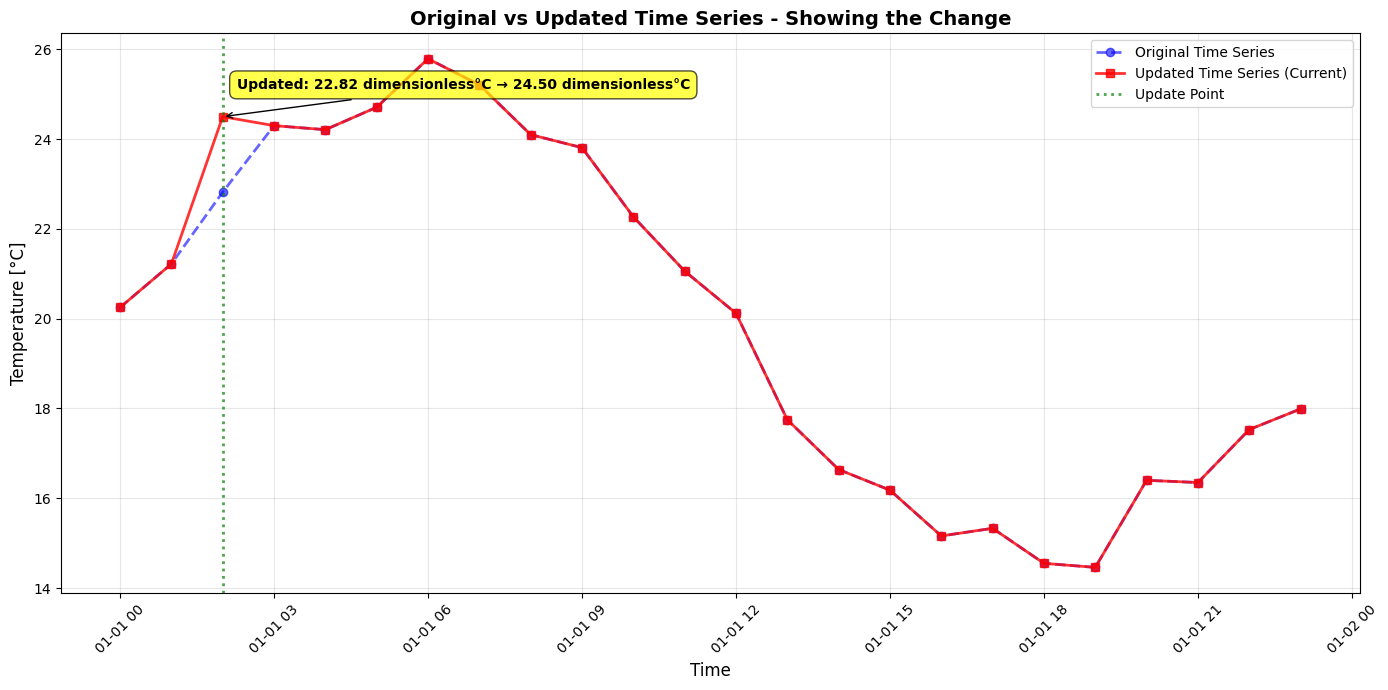

✓ Comparison plot created successfully!

Key observation:
  - The original time series (blue dashed line) shows the initial values
  - The updated time series (red solid line) shows the corrected value at hour 12
  - The green dotted line marks the point where the update was made


In [ ]:
# Read current version (default behavior - only is_current=true)
df_current = td.read(
    series_id=series_id,
    start_valid=base_time,
    end_valid=base_time + timedelta(hours=24),
    all_versions=False  # Only current versions
)

# Create a DataFrame with original values for comparison (from our initial read)
df_original_plot = df_read.copy()

# Plot both versions
plt.figure(figsize=(14, 7))

# Plot original time series
plt.plot(df_original_plot.index, df_original_plot['temperature'], 
         marker='o', linewidth=2, markersize=6, 
         label='Original Time Series', color='blue', alpha=0.6, linestyle='--')

# Plot current (updated) time series
plt.plot(df_current.index, df_current['temperature'], 
         marker='s', linewidth=2, markersize=6, 
         label='Updated Time Series (Current)', color='red', alpha=0.8)

# Highlight the updated point
if update_time in df_current.index:
    updated_value = df_current.loc[update_time, 'temperature']
    original_value_at_update = df_original_plot.loc[update_time, 'temperature']
    
    # Draw a vertical line at the update point
    plt.axvline(x=update_time, color='green', linestyle=':', linewidth=2, alpha=0.7, label='Update Point')
    
    # Annotate the change
    plt.annotate(
        f'Updated: {original_value_at_update:.2f}°C → {updated_value:.2f}°C',
        xy=(update_time, updated_value),
        xytext=(10, 20),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
        fontsize=10,
        fontweight='bold'
    )

plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature [°C]', fontsize=12)
plt.title('Original vs Updated Time Series - Showing the Change', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ Comparison plot created successfully!")
print(f"\nKey observation:")
print(f"  - The original time series (blue dashed line) shows the initial values")
print(f"  - The updated time series (red solid line) shows the corrected value at hour 2")
print(f"  - The green dotted line marks the point where the update was made")


# Let's also create a detailed view showing just the updated time point
# Read with all_versions and return_value_id to see both versions
# Include tags_and_annotations to see tags and annotations
df_update_point = td.read(
    series_id=series_id,
    start_valid=update_time,
    end_valid=update_time + timedelta(hours=1),
    all_versions=True,
    return_value_id=True,
    tags_and_annotations=True
)

print("Detailed view of the updated time point:")
print("=" * 80)

# Get current and original values
df_current_at_update = td.read(
    series_id=series_id,
    start_valid=update_time,
    end_valid=update_time + timedelta(hours=1),
    all_versions=False,
    return_value_id=True
)

if update_time in df_current_at_update.index:
    current_row = df_current_at_update.loc[update_time]
    print(f"\nCurrent Version:")
    print(f"  Valid Time: {update_time}")
    print(f"  Value: {current_row['temperature']}°C")
    print(f"  Value ID: {current_row['value_id']}")
    
    # Get original value from our initial read
    if update_time in df_original_plot.index:
        original_value_at_update = df_original_plot.loc[update_time, 'temperature']
        print(f"\nOriginal Version (from initial data):")
        print(f"  Valid Time: {update_time}")
        print(f"  Value: {original_value_at_update}°C")
        print(f"  Note: Original version is marked is_current=false in database")

print("\n" + "=" * 80)
print(f"\nSummary:")
print(f"  - TimeDB maintains both versions in the database")
print(f"  - The original version is marked is_current=false")
print(f"  - The updated version is marked is_current=true")
print(f"  - Both versions are preserved for audit trail and historical analysis")
print(f"  - Using value_id makes updates simple - no need for run_id, tenant_id, etc.")


## Part 6: Update Multiple Values and View All Versions

Now let's update multiple values (including the one we already updated) and then display all versions of these values in a pandas DataFrame.


In [10]:
# Read the current time series to get value_ids for multiple updates
df_current = td.read(series_id=series_id, return_value_id=True)

# Define multiple time points to update (including the one we already updated at hour 2)
update_times = [
    base_time + timedelta(hours=2),  # Already updated, will update again
    base_time + timedelta(hours=3),  # New update
    base_time + timedelta(hours=4),  # New update
]

# Prepare update records for all time points
updates = []
for update_time in update_times:
    if update_time in df_current.index:
        value_id = df_current.loc[update_time, 'value_id']
        original_value = df_current.loc[update_time, 'temperature']
        
        # Create a new value (slightly different for each)
        new_value = float(original_value) + 2.0  # Add 2°C to each value
        
        update_record = {
            "value_id": value_id,
            "value": new_value,
            "annotation": f"Batch correction: adjusted temperature by +2.0°C",
            "tags": ["batch_corrected", "reviewed"],
            "changed_by": "batch_processor@example.com",
        }
        updates.append(update_record)
        print(f"Prepared update for {update_time}: {original_value}°C → {new_value}°C")

# Execute all updates
if updates:
    result = td.update_records(updates=updates)
    print(f"\n✓ Batch update completed!")
    print(f"  Updated records: {len(result['updated'])}")
    print(f"  Skipped (no-op): {len(result['skipped_no_ops'])}")
else:
    print("No updates to perform")


Prepared update for 2025-01-01 02:00:00+00:00: 24.5 dimensionless°C → 26.5°C
Prepared update for 2025-01-01 03:00:00+00:00: 24.3 dimensionless°C → 26.3°C
Prepared update for 2025-01-01 04:00:00+00:00: 24.21 dimensionless°C → 26.21°C

✓ Batch update completed!
  Updated records: 3
  Skipped (no-op): 0


In [11]:
# Read all versions of the updated time points
# Use all_versions=True to see all historical versions, including change_time
df_all_versions = td.read(
    series_id=series_id,
    start_valid=base_time + timedelta(hours=1),  # Start from hour 1
    end_valid=base_time + timedelta(hours=6),    # End at hour 6 to show the updated values
    all_versions=True,
    return_value_id=True,
    tags_and_annotations=True
)

print("All versions of the updated time points:")
print("=" * 100)
print(f"\nDataFrame shape: {df_all_versions.shape}")
print(f"\nColumns: {list(df_all_versions.columns)}")
print(f"\nIndex type: {type(df_all_versions.index)}")
if isinstance(df_all_versions.index, pd.MultiIndex):
    print(f"Index levels: {df_all_versions.index.names}")
print("\n" + "=" * 100)

# Display the DataFrame
df_all_versions


All versions of the updated time points:

DataFrame shape: (9, 5)

Columns: ['temperature', 'changed_by', 'change_time', 'tags', 'annotation']

Index type: <class 'pandas.core.indexes.multi.MultiIndex'>
Index levels: ['valid_time', 'value_id']



series_key                          temperature                   changed_by  \
valid_time                value_id                                             
2025-01-01 01:00:00+00:00 2               21.22                         None   
2025-01-01 02:00:00+00:00 3               22.82                         None   
                          25               24.5          analyst@example.com   
                          26               26.5  batch_processor@example.com   
2025-01-01 03:00:00+00:00 4                24.3                         None   
                          27               26.3  batch_processor@example.com   
2025-01-01 04:00:00+00:00 5               24.21                         None   
                          28              26.21  batch_processor@example.com   
2025-01-01 05:00:00+00:00 6               24.71                         None   

series_key                                              change_time  \
valid_time                value_id                                    
2025-01-01 01:00:00+00:00 2        2025-12-31 18:02:49.216106+00:00   
2025-01-01 02:00:00+00:00 3        2025-12-31 18:02:49.216106+00:00   
                          25       2025-12-31 18:02:55.195082+00:00   
                          26       2025-12-31 18:05:03.277187+00:00   
2025-01-01 03:00:00+00:00 4        2025-12-31 18:02:49.216106+00:00   
                          27       2025-12-31 18:05:03.277187+00:00   
2025-01-01 04:00:00+00:00 5        2025-12-31 18:02:49.216106+00:00   
                          28       2025-12-31 18:05:03.277187+00:00   
2025-01-01 05:00:00+00:00 6        2025-12-31 18:02:49.216106+00:00   

series_key                                                 tags  \
valid_time                value_id                                
2025-01-01 01:00:00+00:00 2                                None   
2025-01-01 02:00:00+00:00 3                                None   
                          25              [corrected, reviewed]   
                          26        [batch_corrected, reviewed]   
2025-01-01 03:00:00+00:00 4                                None   
                          27        [batch_corrected, reviewed]   
2025-01-01 04:00:00+00:00 5                                None   
                          28        [batch_corrected, reviewed]   
2025-01-01 05:00:00+00:00 6                                None   

series_key                                                                annotation  
valid_time                value_id                                                    
2025-01-01 01:00:00+00:00 2                                                     None  
2025-01-01 02:00:00+00:00 3                                                     None  
                          25         Manual correction: sensor reading was anomalous  
                          26        Batch correction: adjusted temperature by +2.0°C  
2025-01-01 03:00:00+00:00 4                                                     None  
                          27        Batch correction: adjusted temperature by +2.0°C  
2025-01-01 04:00:00+00:00 5                                                     None  
                          28        Batch correction: adjusted temperature by +2.0°C  
2025-01-01 05:00:00+00:00 6                                                     None

## Summary

This notebook demonstrated:

1. **Creating and inserting a time series**: Using `td.insert_run()` to create and store initial time series data

2. **Reading and visualizing time series**: Using `td.read()` with `return_value_id=True` to retrieve data and get value_ids for later updates

3. **Updating time series**: Using `td.update_records()` with dictionary inputs to manually change:
   - **Values**: Correcting erroneous data points
   - **Tags**: Adding quality flags (e.g., "reviewed", "corrected")
   - **Annotations**: Adding explanatory notes about the changes

4. **Reading all versions**: Using `all_versions=True` flag to retrieve both current and historical versions of the data, including:
   - `changed_by`: Who made the change
   - `change_time`: When the change was made
   - `tags` and `annotation`: When `tags_and_annotations=True`

5. **Visualizing changes**: Plotting original vs updated versions to see the differences

6. **Batch updates and version history**: Updating multiple values and viewing complete version history with all metadata columns

**Key Takeaways:**
- TimeDB maintains a complete version history of all changes
- Each update creates a new version while preserving the old version
- The `all_versions=True` flag allows you to access the full audit trail with `changed_by` and `change_time` columns
- The `tags_and_annotations=True` flag includes tags and annotations as DataFrame columns
- When `all_versions=True` and `return_value_id=True`, the DataFrame uses a MultiIndex `(valid_time, value_id)` to preserve multiple versions
- Updates can modify values, annotations, and tags independently or together
- The `is_current` flag indicates which version is the active one
- All versions are preserved for compliance, auditing, and historical analysis
- Using `value_id` makes updates simple - no need for run_id, tenant_id, etc.
